In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from collections import defaultdict
from torch.autograd import Variable
import gc
import sys
import os
from time import gmtime, strftime
from random import shuffle
#gc.set_debug(gc.DEBUG_STATS)
%matplotlib inline

In [4]:
def shuffle_input():
    if os.path.exists('data/input_shuffled.txt'):
            os.remove('data/input_shuffled.txt')
    f = open('data/input_shuffled.txt','w+')
    data_=[]
    data = ''
    for l in open('data/input.txt'):
        if '<start>' in l:
            data+='<start>\n'
        elif '<end>' in l:
            data+='<end>\n'
            data_.append(data)
            data = ''
        else:
            data+=l
        #data.append('\n')
    shuffle(data_)
    data_shuffled=''
    for l in data_:
        data_shuffled += l
    # print(data_shuffled[:1000])
    f.write(data_shuffled)
    f.close()

file_path = "./observations/"
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)
file_path = "./saved_models/"
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)
data = []
j = 0
k = 0
shuffle_input()
for l in open('data/input_shuffled.txt'):
    if '<start>' in l:
        data.append('$')
        j += 1
    elif '<end>' in l:
        data.append('%')
        k += 1
    else:
        for c in range(len(l)):
            data.append(l[c])
    #data.append('\n')
print(j)
print(k)

1124
1124


In [5]:
unique_char = defaultdict(int)
j_ = 0
k_ = 0
for d in data:
    if d == '$':
        j_ += 1
    elif d == '%':
        k_ += 1
    unique_char[d] += 1
#print(len(unique_char))
i = 0
char_idx = defaultdict(int)
for k in unique_char:
    char_idx[k] = i
    i += 1
    
idx_char = defaultdict(str)
for k in char_idx:
    idx_char[char_idx[k]]=k
#print(idx_char)

dat = np.arange(len(char_idx))
len(char_idx)
#char_idx
#print(j_,k_)

95

In [6]:
def one_hot_encoder(char_idx,data):
    output = []
    for i in range(len(data)):
        aux = np.zeros(len(char_idx))
        aux[char_idx[data[i]]] = 1
        output.append(aux.copy())
    return output

def softmaxT(data,T=1):
    temp = torch.exp(data/T)
    aux = torch.sum(temp)
    return temp/aux

In [7]:
oh_data = one_hot_encoder(char_idx,data)

In [8]:
input_data = []
output_data = []
for i in range(len(oh_data)-1):
    input_data.append(oh_data[i].copy())
    output_data.append(oh_data[i+1].copy())
print(len(input_data))
print(len(output_data))
#print(input_data[0],output_data[0])
#print(input_data[1],output_data[1])

487982
487982


In [9]:
split_ratio = 0.8
X_train = input_data[:int(split_ratio*len(input_data))]
Y_train_aux = output_data[:int(split_ratio*len(input_data))]
X_valid = input_data[int(split_ratio*len(input_data)):]
Y_valid_aux = output_data[int(split_ratio*len(input_data)):]
Y_train = []
Y_valid = []
for i in range(len(Y_train_aux)):
    Y_train.append(np.argmax(Y_train_aux[i]))
for i in range(len(Y_valid_aux)):
    Y_valid.append(np.argmax(Y_valid_aux[i]))
print(len(X_train),len(Y_train))
print(len(X_valid),len(Y_valid))

390385 390385
97597 97597


In [11]:
class LSTMMusic(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,num_layers,batch_size=1):
        super(LSTMMusic,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = torch.nn.LSTM(self.input_dim,self.hidden_dim,self.num_layers)
        self.fc = torch.nn.Linear(self.hidden_dim,self.output_dim)
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
#         return (Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim)),
#                Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim)))
        return (Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim).cuda()),
               Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim).cuda()))
    
    def del_hidden(self):
        del self.hidden
        self.hidden = self.init_hidden()
        
    def forward(self,sequence):
        out, _ = self.lstm(sequence.view(len(sequence),self.batch_size,-1),self.hidden)
        out = self.fc(out)
        return out
    
    def hidden_st(self,sequence):
        return self.lstm(sequence.view(len(sequence),self.batch_size,-1),self.hidden)

In [ ]:
class GRUMusic(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,num_layers,batch_size=1):
        super(LSTMMusic,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.gru = torch.nn.GRU(self.input_dim,self.hidden_dim,self.num_layers)
        self.fc = torch.nn.Linear(self.hidden_dim,self.output_dim)
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
#         return (Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim)))
        return (Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_dim).cuda()))
    
    def del_hidden(self):
        del self.hidden
        self.hidden = self.init_hidden()
        
    def forward(self,sequence):
        out, _ = self.gru(sequence.view(len(sequence),self.batch_size,-1),self.hidden)
        out = self.fc(out)
        return out
    
    def hidden_st(self,sequence):
        return self.gru(sequence.view(len(sequence),self.batch_size,-1),self.hidden)

In [20]:
INPUT_DIM = len(char_idx)
OUTPUT_DIM = len(char_idx)
HIDDEN_DIM = 100
BATCH_SIZE = 1
NUM_LAYERS = 1
char_size = 25
epochs = 50

model = LSTMMusic(INPUT_DIM,HIDDEN_DIM,OUTPUT_DIM,NUM_LAYERS,BATCH_SIZE)
model.cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-4,nesterov=True)

eps = []
tr_loss = []
va_loss = []
model.hidden = model.init_hidden()
ts = strftime("%Y-%m-%d__%Hh%Mm%Ss_", gmtime())
for epoch in range(epochs):
    tot_loss = 0
    val_loss = 0
    min_val_loss = 999999999999999
    iteration = 0
    i = 0
    l = open('./observations/lstm_music_trial_'+str(ts)+'.txt','a+')
    while i < len(X_train):
        inputs = X_train[i:min(i+char_size,len(X_train))]
        outputs = Y_train[i:min(i+char_size,len(X_train))]
        optimizer.zero_grad()
        ip = Variable(torch.from_numpy(np.array(inputs)).float().cuda())
        del inputs
        op = torch.from_numpy(np.array(outputs))
        op = Variable(op.type(torch.LongTensor).cuda())
        del outputs
        out = model(ip)
        out = out.view(out.data.shape[0],out.data.shape[2])
        loss = loss_fn(out,op)
        del ip, op, out
        loss.backward()
        optimizer.step()
        tot_loss += float(loss.cpu().data.numpy())
        if i%(int(len(X_train)/100)) == 0:
            print('--',i,loss.data[0])
        i += char_size
    i=0
    while i < len(X_valid):
        inputs = X_valid[i:min(i+char_size,len(X_valid))]
        outputs = Y_valid[i:min(i+char_size,len(X_valid))]
        optimizer.zero_grad()
        ip = Variable(torch.from_numpy(np.array(inputs)).float().cuda())
        del inputs
        op = torch.from_numpy(np.array(outputs))
        op = Variable(op.type(torch.LongTensor).cuda())
        del outputs
        out = model(ip)
        out = out.view(out.data.shape[0],out.data.shape[2])
        loss = loss_fn(out,op)
        del ip, op, out
        val_loss += float(loss.cpu().data.numpy())
        if i%(int(len(X_train)/100)) == 0:
            print('--',i,loss.data[0])
        i += char_size
        
    #model.del_hidden()
    print(epoch,'Train Loss : ',tot_loss/len(X_train),'Val Loss : ',val_loss/len(X_valid))
    eps.append(epoch)
    tr_loss.append(tot_loss/len(X_train))
    va_loss.append(val_loss/len(X_valid))
    l.write(str(epoch)+' T '+str(tot_loss/len(X_train))+' V '+str(val_loss/len(X_valid))+'\n')
    l.close()
    if val_loss/len(X_valid) <= min_val_loss:
        min_val_loss = val_loss/len(X_valid)
        iteration = epoch
        if os.path.exists('saved_models/model' + str(ts) + '__' + '__.pt'):
            os.remove('saved_models/model' + str(ts) + '__' + '__.pt')
        torch.save(model,'saved_models/model' + str(ts) + '__' + '__.pt')

fig = plt.figure()
plt.plot(eps,tr_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(eps,va_loss)
plt.legend(['Train Loss','Valid Loss'])
plt.show()
fig.savefig('observations/LossPlot_' + str(ts), dpi=fig.dpi)

-- 0 4.552942276000977
-- 97575 4.1670098304748535
-- 195150 3.770622968673706
-- 292725 2.8869309425354004
-- 390300 2.4725356101989746
-- 0 2.7523651123046875
-- 97575 2.35771107673645
0 Train Loss :  0.13102814901121979 Val Loss :  0.11136392024796628
-- 0 2.918945074081421


/opt/conda/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type LSTMMusic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


-- 97575 2.7468018531799316
-- 195150 2.717252731323242
-- 292725 1.804925560951233
-- 390300 2.028649091720581
-- 0 2.3350582122802734
-- 97575 2.1144299507141113
1 Train Loss :  0.09542026163813279 Val Loss :  0.09036625495671222
-- 0 2.59138560295105
-- 97575 1.3012081384658813
-- 195150 2.241391658782959
-- 292725 1.7325364351272583
-- 390300 1.8582011461257935
-- 0 2.2685980796813965
-- 97575 2.046712875366211
2 Train Loss :  0.08225377819520772 Val Loss :  0.08254050555084519
-- 0 2.507265090942383
-- 97575 0.636146605014801
-- 195150 1.7866672277450562


KeyboardInterrupt: 

In [ ]:
model2 = torch.load('saved_models/model' + str(ts) + '__' + str(epochs-1) + '__.pt')

In [14]:
prefix = '$'
T = 0.7
pref_oh = one_hot_encoder(char_idx,prefix)

ip = Variable(torch.from_numpy(np.array(pref_oh)).float().cuda())
out = model(ip)
final_out = out[-1,:,:]
dist = softmaxT(final_out.data,T).cpu().numpy()
dist = dist.reshape(dist.shape[1])
seq_len = 800
output = []
prev_char = np.random.choice(dat,p=dist)
output.append(prev_char)
for i in range(seq_len):
    x = prev_char
    #print(dist)
    #output.append(x)
    ip = np.zeros((1,len(char_idx)))
    ip[0,x]=1
    #ip = Variable(torch.from_numpy(np.array(ip)).float())
    ip = Variable(torch.from_numpy(np.array(ip)).float().cuda())
    out = model(ip)
    aux = softmaxT(out[-1,:,:].data,T).cpu().numpy()
    aux = aux.reshape(aux.shape[1])
    prev_char = np.random.choice(dat,p=aux)
    output.append(prev_char)

output_seq = []
for i in range(len(output)):
    output_seq.append(idx_char[output[i]])
#print(output_seq)
l = open('./observations/generated_music_'+str(ts)+'.txt','a+')
gen_text = ''
for i in output_seq:
    if i == '\n':
        l.write(gen_text)
        print(gen_text)
        gen_text = ''
    elif i == '$':
        gen_text = gen_text + '<start>\n'
    elif i == '%':
        gen_text = gen_text + '<end>\n'
    else:
        gen_text = gen_text + str(i)
l.write(gen_text)
print(gen_text)

X:||  poban- erid3 ec2 A f|11 B2 AB|~e2E|:in-1/ | AG c BB2| |2 ee (3 |c :|1 | GB :Ele2 GAA|d ele/ |:|
R: B c| d2a G3g2 d| |d/fro) AG2BBc|:1
Z:|b
Cadc GF f2 c #8
bonal
<end>
<start>
X:2 and2 e B/ ED FEE~gf| M:1 dc| F fed u d g | e d2 Lan c| A GBA4-6 d ared c| A atour
Z:|  AGB2 e B| |
T:|d ^FEF2 B2as (3c/ AB3 A|chnaleg B>A/B e dcd FA B H:L:|:| | BAdc2A3 d f/2 AGA|(3 | |
T:|F e
R:||
Thee, A2d2| d| | |Bd "DF Be
utlkss AG2 fe |1 A2g dBc c/2 DDEF2 D2 |
fgf3>FGBd eon-05
<end>
<start>
X:|
R:18
T:D|||:Thn- G| GG BAGB/d A f|
|d2||| |Bc| a dfr e,G e wanM:| d2g e2B "G2Bc2GB31 cd:D d2 | | g/2 are2 | e d2 GB2ABB C:|:M:1 B2 BAGB2 |dfd:ia>Bc f BED
Z:W:2Bc2 G/ G2 FAGBAB B2gag | ay
K:C:1/b2AGG2 | GA| d cBcd2 | f2 d2e|f>AF/BF2fg4 B3/2 G2 dB22c4- :Bc | g2 d:DED2 B:|f AF4 T:| B2 e B2D:1/2 |
Ke2 fsc|:|1/4fz | ck d H:ig2BA ded2g | "A G2


In [15]:
i = 0
test_seq = []
seq_char = []
while True:
    test_seq.append(oh_data[i])
    seq_char.append(data[i])
    if data[i] == '%':
        break
    i += 1
# test_seq

In [16]:
activations = []

for i in range(len(test_seq)):
    ip = Variable(torch.from_numpy(test_seq[i]).float().cuda()).view(1,-1)
    #print(ip.data.shape)
    out,_ = model.hidden_st(ip)
    out = out.view(out.data.shape[2])
    #print(out.data.shape)
    activations.append(out.data.cpu().numpy())
activations = np.array(activations)
activations = activations[:600,:]
seq = np.reshape(np.array(seq_char[:600]),(20,-1))
print(activations.shape)
print(seq.shape)

(600, 100)
(20, 30)


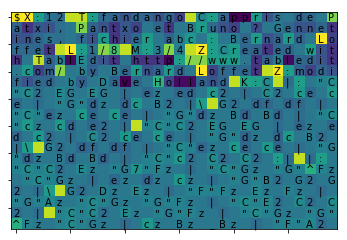

In [18]:
neuron = np.reshape(activations[:,0],(20,-1))
neuron.shape

fig, ax = plt.subplots()
ax.imshow(neuron)
#plt.colorbar()
ax.set_xticklabels([])
ax.set_yticklabels([])
#plt.colorbar(fig,cax=ax)

xaxis = np.arange(0,neuron.shape[1])
yaxis = np.arange(0,neuron.shape[0])
x,y = np.meshgrid(xaxis,yaxis)
#print(x,y)
for x_val, y_val in zip(x.flatten(),y.flatten()):
    ax.text(x_val,y_val,seq[y_val,x_val],va='center',ha='center')
plt.show()